# FTDI Device Info

In [2]:
from pyftdi.ftdi import Ftdi

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            # entry can be (UsbDeviceDescriptor, interface) or similar
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            # UsbDeviceDescriptor fields
            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04x}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04x}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : {serial or 'Unknown'}")
            print(f"   Description : {description or 'Unknown'}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : ￿￿￿￿￿￿￿￿
   Description : ￿￿￿￿￿￿
   Interfaces  : 1



In [3]:
from pyftdi.ftdi import Ftdi

def safe_to_hex_string(value):
    """Return UTF-8 string if printable, else show hex representation."""
    if value is None:
        return 'None'
    try:
        if all(0x20 <= ord(c) <= 0x7E for c in value):
            return value  # printable ASCII
        else:
            raise UnicodeEncodeError
    except Exception:
        return ' '.join(f'{ord(c):02X}' for c in value)

devices = Ftdi.list_devices()

if not devices:
    print("❌ No FTDI devices found.")
else:
    for entry in devices:
        try:
            if isinstance(entry, tuple):
                dev_desc = entry[0]
                interfaces = entry[1] if len(entry) > 1 else []
            else:
                dev_desc = entry
                interfaces = []

            vendor = getattr(dev_desc, "vid", None)
            product = getattr(dev_desc, "pid", None)
            serial = getattr(dev_desc, "sn", None)
            description = getattr(dev_desc, "description", None)

            print("✅ FTDI Device Found:")
            print(f"   Vendor ID   : {vendor:04X}" if vendor else "   Vendor ID   : Unknown")
            print(f"   Product ID  : {product:04X}" if product else "   Product ID  : Unknown")
            print(f"   Serial No.  : 0x{safe_to_hex_string(serial)}")
            print(f"   Description : 0x{safe_to_hex_string(description)}")
            print(f"   Interfaces  : {interfaces}")
            print()

        except Exception as e:
            print(f"⚠️ Could not parse entry {entry}: {e}")


✅ FTDI Device Found:
   Vendor ID   : 0403
   Product ID  : 6014
   Serial No.  : 0xFFFF FFFF FFFF FFFF FFFF FFFF FFFF FFFF
   Description : 0xFFFF FFFF FFFF FFFF FFFF FFFF
   Interfaces  : 1



# FTDI FT232H Sanity Test

In [4]:
from pyftdi.ftdi import Ftdi
from pyftdi.i2c import I2cController
from IPython.display import display, Markdown
import traceback

display(Markdown("## 🔍 FT232H Sanity Test"))

try:
    display(Markdown("**🔹 Scanning for FTDI devices...**"))
    Ftdi.show_devices()
except Exception as e:
    display(Markdown(f"❌ **Could not list FTDI devices:** `{e}`"))
    traceback.print_exc()
else:
    try:
        display(Markdown("**🔹 Initializing I2C interface...**"))
        i2c = I2cController()
        i2c.configure('ftdi://ftdi:232h/1')
        #i2c.configure('ftdi://ftdi:232h/1', frequency=400000)  # 400 kHz
        #i2c.configure('ftdi://ftdi:232h/1', frequency=1e6)  # 1 MHz

        freq = i2c.frequency
        display(Markdown(f"✅ **Connected to FT232H via I2C** at **{freq/1000:.1f} kHz**"))

        # ✅ Manually scan I2C addresses 0x03–0x77
        display(Markdown("**🔹 Scanning I2C bus...**"))
        found = []
        for addr in range(0x03, 0x78):
            try:
                port = i2c.get_port(addr)
                port.read(1)  # Try reading one byte (safe test)
                found.append(addr)
            except Exception:
                # No device responded
                pass

        if found:
            md = "\n".join([f"- `0x{addr:02X}`" for addr in found])
            display(Markdown(f"✅ **Found I2C devices:**\n{md}"))
        else:
            display(Markdown("⚠️ **No I2C devices detected.** Check wiring or power."))

        i2c.terminate()
        display(Markdown("✅ **Test complete — FT232H is working properly.**"))

    except Exception as e:
        display(Markdown(f"❌ **Failed to communicate with FT232H:** `{e}`"))
        traceback.print_exc()


## 🔍 FT232H Sanity Test

**🔹 Scanning for FTDI devices...**

Available interfaces:
  ftdi://ftdi:232h:1/1  (￿￿￿￿￿￿)



**🔹 Initializing I2C interface...**

✅ **Connected to FT232H via I2C** at **100.0 kHz**

**🔹 Scanning I2C bus...**

✅ **Found I2C devices:**
- `0x68`

✅ **Test complete — FT232H is working properly.**

# INA219

In [105]:
from pyftdi.i2c import I2cController
import struct

INA219_ADDR = 0x40
REG_BUS_VOLTAGE = 0x02  # Bus voltage register
REG_SHUNT_VOLTAGE = 0x01
REG_CONFIG = 0x00

# Initialize I2C via FT232H
i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1')  # or your custom URL

print(f"✅ Connected to FT232H. Scanning for INA219 at address 0x{INA219_ADDR:02X}...")

# Get port for INA219
ina = i2c.get_port(INA219_ADDR)

try:
    def write_config(ina_port, badc, sadc, mode=0x7, pga=3, brng=1):
        """
        Write CONFIG register to INA219.
    
        Parameters:
            badc : Bus ADC config (0x0–0xF)
                   0x0–0x3  → 9–12-bit resolution (single-shot)
                   0x9–0xF → 12-bit with 2–128 sample averaging
            sadc : Shunt ADC config (same as badc)
            mode : Operating mode (default: 0x7 = continuous shunt+bus)
            pga  : Shunt voltage range gain
                   0 = ±40 mV, 1 = ±80 mV, 2 = ±160 mV, 3 = ±320 mV
            brng : Bus voltage range
                   0 = 16 V, 1 = 32 V
        """
        # Construct 16-bit CONFIG register
        config = (brng << 13) | (pga << 11) | (badc << 7) | (sadc << 3) | mode
    
        # Write to register 0x00
        ina_port.write([0x00, (config >> 8) & 0xFF, config & 0xFF])
    
        print(f"✅ Wrote CONFIG: 0x{config:04X}")
        print(f"   BRNG : {brng} (Bus Voltage Range: {'32V' if brng else '16V'})")
        print(f"   PGA  : {pga} (Shunt Range: ±{40 * (2 ** pga)} mV)")
        print(f"   BADC : 0x{badc:X}")
        print(f"   SADC : 0x{sadc:X}")
        print(f"   MODE : 0x{mode:X}")

    def read_config(ina_port):
        """
        Reads and decodes the INA219 CONFIG register (0x00) from the given I2C port.
        Prints a human-readable breakdown of all fields.
        """
        REG_CONFIG = 0x00
    
        try:
            raw = ina_port.read_from(REG_CONFIG, 2)
            config = struct.unpack('>H', raw)[0]
        except Exception as e:
            print(f"❌ Error reading CONFIG register: {e}")
            return
    
        #print(f"\n🛠️  INA219 CONFIG Register: 0x{config:04X}")
    
        # Decode fields
        brng = (config >> 13) & 0x01
        pga  = (config >> 11) & 0x03
        badc = (config >> 7)  & 0x0F
        sadc = (config >> 3)  & 0x0F
        mode = config & 0x07
    
        # Decode BRNG
        brng_str = "32V" if brng == 1 else "16V"
    
        # Decode PGA
        pga_dict = {
            0: "±40 mV (Gain /1)",
            1: "±80 mV (Gain /2)",
            2: "±160 mV (Gain /4)",
            3: "±320 mV (Gain /8)",
        }
        pga_str = pga_dict.get(pga, "Unknown")
    
        # Decode BADC/SADC
        def adc_setting(value):
            if value <= 0x3:
                return f"{9 + value}-bit"
            elif 0x9 <= value <= 0xF:
                samples = 2 ** (value - 0x8)
                return f"12-bit, {samples} samples avg"
            else:
                return "Reserved/Invalid"
    
        # Decode MODE
        mode_dict = {
            0b000: "Power-down",
            0b001: "Shunt voltage, triggered",
            0b010: "Bus voltage, triggered",
            0b011: "Shunt + Bus, triggered",
            0b100: "ADC off",
            0b101: "Shunt voltage, continuous",
            0b110: "Bus voltage, continuous",
            0b111: "Shunt + Bus, continuous",
        }
        mode_str = mode_dict.get(mode, "Unknown")
    
        # Print decoded values
        print(f"✅ Read CONFIG: 0x{config:04X}")
        print(f"   Bus Voltage Range (BRNG):   {brng_str}")
        print(f"   PGA (Shunt Voltage Range):  {pga_str}")
        print(f"   BADC (Bus ADC):             0x{badc:X} → {adc_setting(badc)}")
        print(f"   SADC (Shunt ADC):           0x{sadc:X} → {adc_setting(sadc)}")
        print(f"   Operating Mode:             0x{mode:X} → {mode_str}")

        
    write_config(ina, badc=0xF, sadc=0xF, pga=0, brng=1)  # 128x averaging for both
    read_config(ina)
        

    # Read BUS VOLTAGE (2 bytes)
    raw_bus = ina.read_from(REG_BUS_VOLTAGE, 2)
    bus_val = struct.unpack('>H', raw_bus)[0]
    voltage_mv = (bus_val >> 3) * 4  # Each bit = 4 mV
    print(f"🔋 Bus Voltage: {voltage_mv} mV")

    # Read SHUNT VOLTAGE (2 bytes, signed)
    raw_shunt = ina.read_from(REG_SHUNT_VOLTAGE, 2)
    shunt_val = struct.unpack('>h', raw_shunt)[0]
    shunt_mv = shunt_val * 0.01  # 10uV per bit = 0.01mV
    print(f"🔌 Shunt Voltage: {shunt_mv:.2f} mV")

except Exception as e:
    print(f"❌ Could not communicate with INA219 at 0x{INA219_ADDR:02X}: {e}")

finally:
    i2c.terminate()


✅ Connected to FT232H. Scanning for INA219 at address 0x40...
✅ Wrote CONFIG: 0x27FF
   BRNG : 1 (Bus Voltage Range: 32V)
   PGA  : 0 (Shunt Range: ±40 mV)
   BADC : 0xF
   SADC : 0xF
   MODE : 0x7
✅ Read CONFIG: 0x27FF
   Bus Voltage Range (BRNG):   32V
   PGA (Shunt Voltage Range):  ±40 mV (Gain /1)
   BADC (Bus ADC):             0xF → 12-bit, 128 samples avg
   SADC (Shunt ADC):           0xF → 12-bit, 128 samples avg
   Operating Mode:             0x7 → Shunt + Bus, continuous
🔋 Bus Voltage: 12 mV
🔌 Shunt Voltage: -0.01 mV


In [106]:
from pyftdi.i2c import I2cController

i2c = I2cController()
i2c.configure('ftdi://ftdi:232h/1', frequency=400000)
ina = i2c.get_port(0x40)

read_config(ina)


✅ Read CONFIG: 0x27FF
   Bus Voltage Range (BRNG):   32V
   PGA (Shunt Voltage Range):  ±40 mV (Gain /1)
   BADC (Bus ADC):             0xF → 12-bit, 128 samples avg
   SADC (Shunt ADC):           0xF → 12-bit, 128 samples avg
   Operating Mode:             0x7 → Shunt + Bus, continuous


In [107]:
from pyftdi.i2c import I2cController
import struct
import time
from datetime import datetime

INA219_ADDR = 0x40
REG_BUS_VOLTAGE = 0x02
REG_SHUNT_VOLTAGE = 0x01
RSHUNT = 0.1  # ohms

SAMPLE_TIME = 1

i2c = I2cController()
#i2c.configure('ftdi://ftdi:232h/1')
i2c.configure('ftdi://ftdi:232h/1', frequency=1e6)  # 400 kHz

ina = i2c.get_port(INA219_ADDR)
read_config(ina)

#print("🔄 Sampling INA219. Stop the cell (or press Ctrl+C) to end.\n")
print("🔄 Sampling INA219 every {} ms. Stop the cell (or press Ctrl+C) to end.\n".format(SAMPLE_TIME*1000))

samples = []

try:
    while True:
        ts = datetime.now().strftime('%H:%M:%S.%f')[:-3]

        # Read bus voltage
        raw_bus = ina.read_from(REG_BUS_VOLTAGE, 2)
        bus_val = struct.unpack('>H', raw_bus)[0]
        bus_mv = (bus_val >> 3) * 4

        # Read shunt voltage
        raw_shunt = ina.read_from(REG_SHUNT_VOLTAGE, 2)
        shunt_val = struct.unpack('>h', raw_shunt)[0]
        shunt_mv = shunt_val * 0.01

        # Compute current in mA
        current_ma = shunt_mv / RSHUNT

        print(f"[{ts}] Bus: {bus_mv} mV | Shunt: {shunt_mv:.2f} mV | Current: {current_ma:.2f} mA")

        samples.append((ts, bus_mv, shunt_mv, current_ma))
        time.sleep(SAMPLE_TIME)

except KeyboardInterrupt:
    print("\n⏹️ Sampling stopped by user.")

finally:
    i2c.terminate()
    print(f"📈 {len(samples)} samples collected.")


✅ Read CONFIG: 0x27FF
   Bus Voltage Range (BRNG):   32V
   PGA (Shunt Voltage Range):  ±40 mV (Gain /1)
   BADC (Bus ADC):             0xF → 12-bit, 128 samples avg
   SADC (Shunt ADC):           0xF → 12-bit, 128 samples avg
   Operating Mode:             0x7 → Shunt + Bus, continuous
🔄 Sampling INA219 every 1000 ms. Stop the cell (or press Ctrl+C) to end.

[12:42:46.570] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:47.608] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:48.665] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:49.722] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:50.777] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:51.833] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:52.889] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:53.944] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:54.999] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 mA
[12:42:56.054] Bus: 12 mV | Shunt: -0.01 mV | Current: -0.10 m

In [108]:
import pandas as pd
from datetime import datetime

# If not already a DataFrame
df = pd.DataFrame(samples, columns=['timestamp', 'bus_mv', 'shunt_mv', 'current_ma'])

# Parse timestamps if they’re strings like '12:03:45.123'
df['parsed_time'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S.%f')

# Calculate time differences between samples in seconds
df['delta_s'] = df['parsed_time'].diff().dt.total_seconds()

# Drop the first NaN row
deltas = df['delta_s'].dropna()

# Compute statistics
avg_dt = deltas.mean()
min_dt = deltas.min()
max_dt = deltas.max()
std_dt = deltas.std()
sampling_rate = 1 / avg_dt if avg_dt else 0

print("📊 Sampling Time Statistics")
print(f"    Samples collected   : {len(df)}")
print(f"    Avg. interval       : {avg_dt:.3f} s")
print(f"    Min/Max interval    : {min_dt:.3f} s / {max_dt:.3f} s")
print(f"    Std. deviation      : {std_dt:.4f} s")
print(f"    Effective rate      : {sampling_rate:.2f} samples/sec")


📊 Sampling Time Statistics
    Samples collected   : 24
    Avg. interval       : 1.054 s
    Min/Max interval    : 1.038 s / 1.058 s
    Std. deviation      : 0.0042 s
    Effective rate      : 0.95 samples/sec


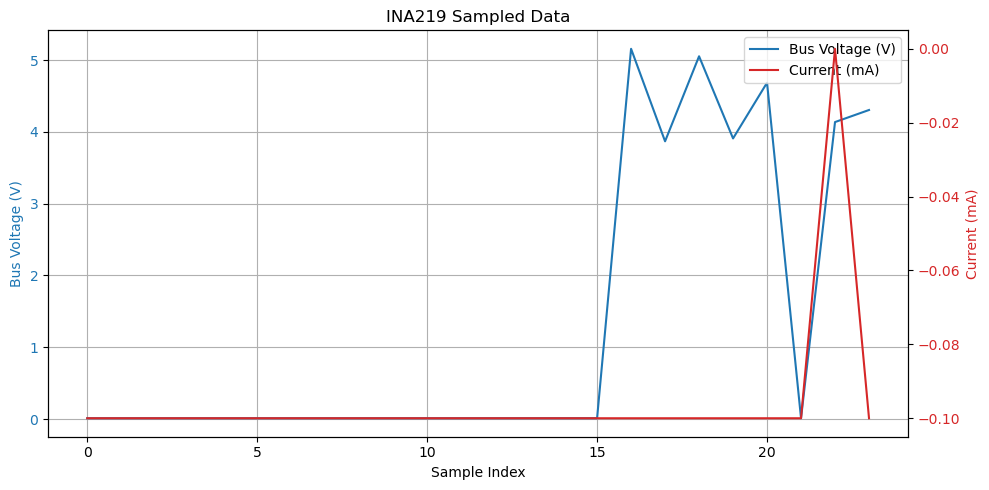

In [109]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to DataFrame
df = pd.DataFrame(samples, columns=['timestamp', 'bus_mv', 'shunt_mv', 'current_ma'])

# Convert bus voltage to volts for plotting
df['bus_v'] = df['bus_mv'] / 1000

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot bus voltage (left Y-axis)
ax1.set_title("INA219 Sampled Data")
ax1.set_xlabel("Sample Index")
ax1.set_ylabel("Bus Voltage (V)", color='tab:blue')
line1, = ax1.plot(df['bus_v'], color='tab:blue', label="Bus Voltage (V)")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid()
#ax1.legend()

# Plot current (right Y-axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Current (mA)", color='tab:red')
line2, = ax2.plot(df['current_ma'], color='tab:red', label="Current (mA)")
ax2.tick_params(axis='y', labelcolor='tab:red')
#ax2.legend()

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right') 

plt.tight_layout()
plt.show()
